# Waves
##### A GWDST notebook for managing the huge dataset that is all BTAU parameterized GW outputs for GWDST WACCM run. Check ../scripts/waves.py for most recent analysis!

### Input and data

In [26]:
%matplotlib inline

from glob import glob
import numpy as np
from scipy.stats import lognorm
import pandas as pd
import xarray as xr
import xarray.ufuncs as xu
import matplotlib.pyplot as plt
import seaborn as sns
#import cartopy.crs as ccrs

from dask.distributed import Client

sns.set(context='talk', palette='colorblind', style='ticks')

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:32995 Dashboard: http://127.0.0.1:8787,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


In [3]:
ds = xr.open_mfdataset(sorted(glob('/glade/scratch/mcamron/archive/f.c54120.FWscHIST.f09_f09.gwdst/atm/hist/f.c54120.FWscHIST.f09_f09.gwdst.cam.h1.2002-0[6,7]*')))

ds = ds.sel(lat=slice(-20,20))

# Separate out GW flux vars and convert Pa -> mPa
gwx = xr.Dataset({var: ds[var] for var in ds.data_vars if 'BTAUX' in var}) * 1000
gwy = xr.Dataset({var: ds[var] for var in ds.data_vars if 'BTAUY' in var}) * 1000

Now I will read in and find the magnitude of tau from the individual directions and save it separately to have and to save time!

In [ ]:
tau = xr.Dataset({str(i): xu.sqrt(xu.square(gwx[x]) + xu.square(gwy[y])) for (i, (x,y)) in enumerate(zip(gwx.data_vars, gwy.data_vars))})

tau.to_netcdf('/glade/scratch/mcamron/output/gwdst/tau_magnitude.nc')

Let's make sure to read that in now instead of running these calculations.

In [6]:
tau = xr.open_dataset('/glade/scratch/mcamron/output/gwdst/tau_magnitude.nc', chunks={'time': 61})

In [7]:
bins = np.arange(0, 200, 1)
hist = 0

for (i, x) in enumerate(tau.data_vars):
    (h, edges) = np.histogram(tau['%d' % i], bins=bins)
    hist += h

Similarly to above, I will save this so that I don't have to keep repeating these calculations!

In [15]:
tau_hist = xr.DataArray(hist, coords=[('r_edge', edges[1:])])
tau_hist

<xarray.DataArray (r_edge: 199)>
array([79161562676,    80707748,    33737029,    18138879,    10994981,
           7238132,     4990088,     3593736,     2646810,     2013014,
           1558100,     1222431,      967231,      772450,      632292,
            513906,      428703,      356158,      299187,      253253,
            212527,      180657,      154723,      132456,      113940,
             96854,       84105,       73708,       65661,       56911,
             50046,       42407,       37337,       34263,       31243,
             27478,       22506,       22340,       18987,       17131,
             15584,       14165,       12788,       11093,        9848,
              9413,        7816,        7680,        6972,        6679,
              5431,        4886,        4496,        4260,        3706,
              3746,        3150,        3348,        2809,        2658,
              2173,        2217,        1799,        1835,        1859,
              1464,        1603

In [16]:
tau_hist.to_netcdf('/glade/scratch/mcamron/output/gwdst/tau_hist.nc')

In [34]:
tau_hist = tau_hist / tau_hist.sum()

In [36]:
tau

<xarray.Dataset>
Dimensions:  (lat: 42, lev: 70, lon: 288, time: 1464)
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * lev      (lev) float64 5.96e-06 9.827e-06 1.62e-05 2.671e-05 4.404e-05 ...
  * lat      (lat) float64 -19.32 -18.38 -17.43 -16.49 -15.55 -14.61 -13.66 ...
  * time     (time) datetime64[ns] 2002-06-01 2002-06-01T00:59:59 ...
Data variables:
    0        (time, lev, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    1        (time, lev, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    2        (time, lev, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    3        (time, lev, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    4        (time, lev, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    5        (time, lev, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    6        (time, lev, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    7        (time, lev, lat, lon) float

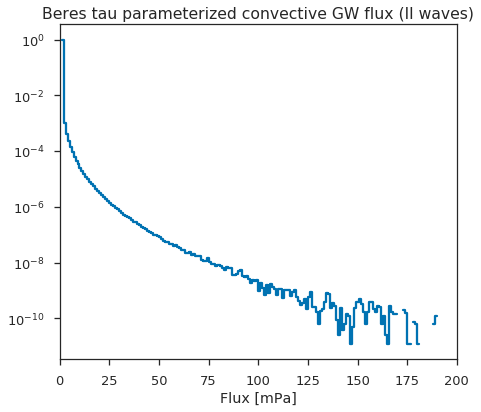

In [35]:
f, ax = plt.subplots(figsize=(7, 6))
ax.step(tau_hist['r_edge'].values, tau_hist.values, where='post')
ax.plot()

ax.semilogy()
ax.set_xlim(0, 200)

ax.set_title('Beres tau parameterized convective GW flux (ll waves)')
ax.set_xlabel('Flux [mPa]')

plt.tight_layout()
#f.savefig('../figures/waves/dist_flux.png')